In [5]:
import pandas as pd
import sys

sys.path.append('../_styling/')
from style import prep_plot, GRAY1, GRAY2, GRAY3, BLACK

In [6]:
import requests 
import json 
import pandas as pd 
from urllib.parse import urlencode, urlunparse
from bs4 import BeautifulSoup

def encode_url(base_url, params):
    """
    Encodes a URL with the given base URL and parameters.

    Args:
        base_url (str): The base URL to which parameters will be added.
        params (dict): A dictionary of query parameters to be encoded and attached to the base URL.

    Returns:
        str: The complete URL-encoded string.
    """
    # Encode the query parameters
    query_string = urlencode(params)
    
    # Construct the full URL
    encoded_url = f"{base_url}?{query_string}"
    
    return encoded_url

def extract_data_from_html(html_content): 
    '''
    Extracts the ngrams data from the HTML content. 

    Args:
        html_content (str): The HTML content to extract the data from. 

    Returns:
        list: The ngrams data (frequencies). 
    '''

    soup = BeautifulSoup(html_content, 'html.parser')
    script_tag = soup.find('script', id='ngrams-data')
    json_str = script_tag.string if script_tag else '[]'
    data = json.loads(json_str)

    return data[0]['timeseries']

def get_ngrams_data(query, year_start, year_end, corpus="eng_2019", smoothing="0"): 
    '''
    Downloads the ngrams data for a given query. 

    Args:
        query (str): The query to search for.
        year_start (str): The start year for the query.
        year_end (str): The end year for the query.
        corpus (str): The corpus to search in.
        smoothing (str): The smoothing parameter for the query.
    
    Returns:
        pd.DataFrame: The ngrams data with columns 'year' and 'frequency'.
    '''

    base_url = "https://books.google.com/ngrams/graph"
    params = {
        "content": query,
        "year_start": year_start,
        "year_end": year_end,
        "corpus": corpus,
        "smoothing": smoothing
    }
    encoded_url = encode_url(base_url, params)
    response = requests.get(encoded_url)

    frequency_data = extract_data_from_html(response.content)
    years = list(range(int(year_start), int(year_end) + 1))

    return pd.DataFrame({'year': years, 'frequency': frequency_data})

def download_artificial_intelligence_data():
    '''
    Downloads the ngrams data for the query "artificial intelligence" from 1950 to 2019.
    '''

    query = "artificial intelligence"
    year_start = "1950"
    year_end = "2019"
    data = get_ngrams_data(query, year_start, year_end)
    data.to_csv("ai_ngram_data.csv", index=False) # Save the data to a CSV file
    return data

In [7]:
df = download_artificial_intelligence_data()
df.head(1)

,year,frequency
0,1950,6.281172e-09


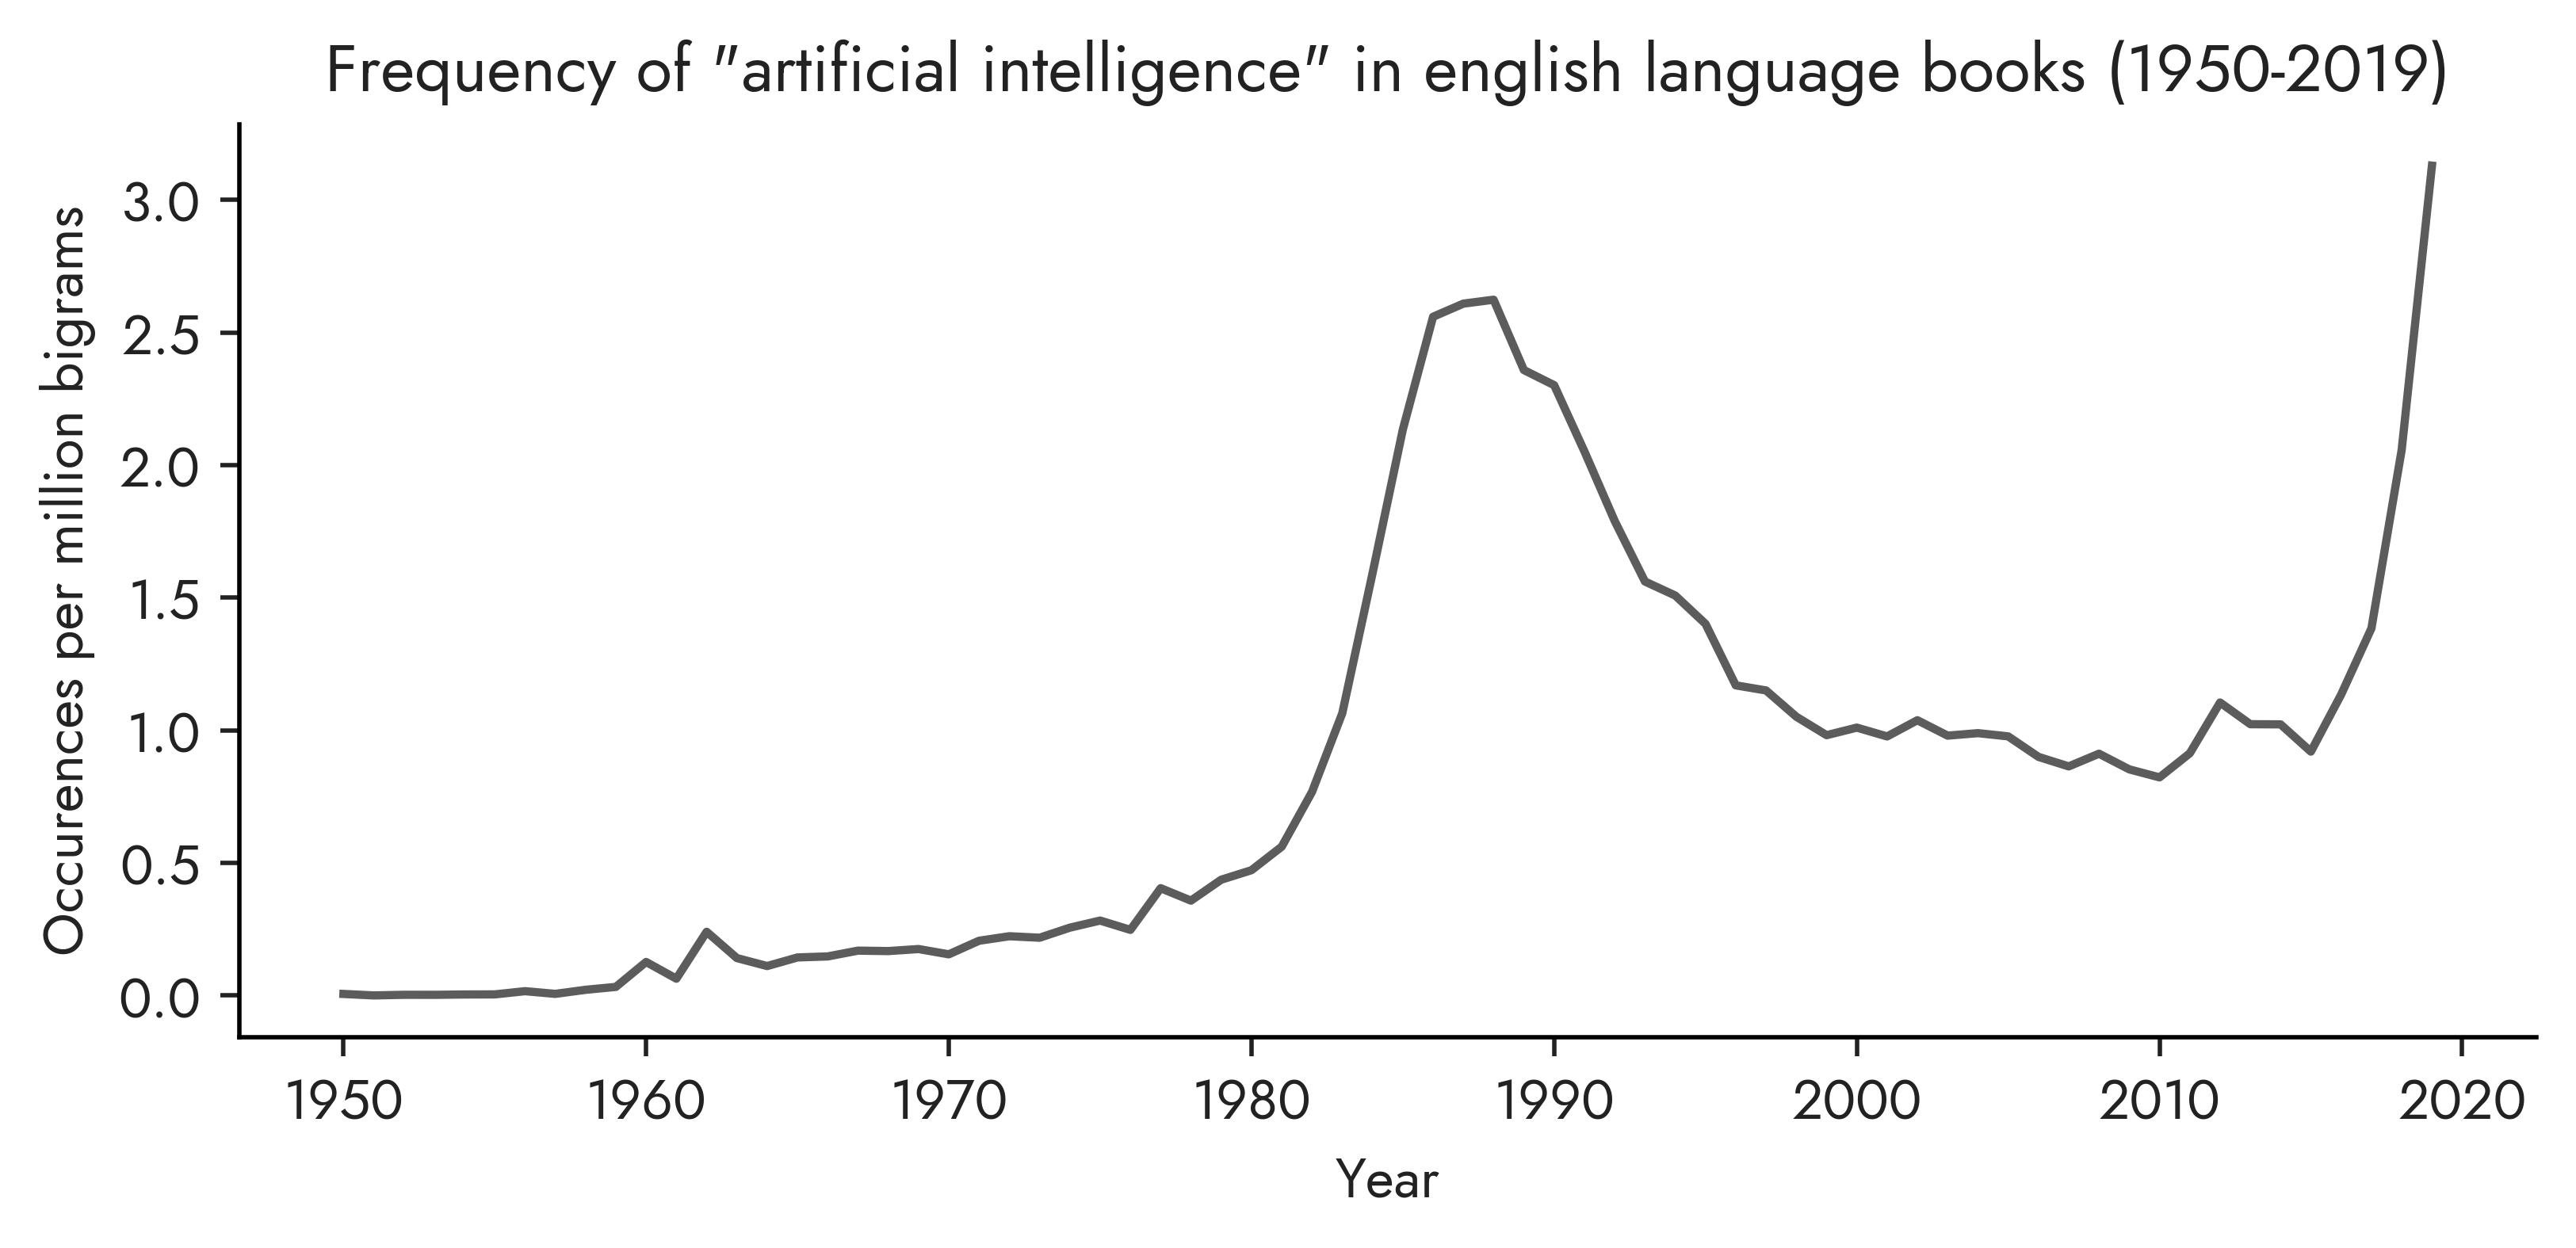

In [8]:
plt = prep_plot()
plt.plot(df['year'], df['frequency']*1e6, color=GRAY1)
plt.xlabel('Year')
plt.ylabel('Occurences per million bigrams')
plt.title('Frequency of "artificial intelligence" in english language books (1950-2019)')
plt.ticklabel_format(style='plain', axis='y')
plt.savefig("ai_ngrams.png")